In [1]:
%matplotlib inline
%precision 16
import numpy
import scipy.sparse as sparse
import scipy.sparse.linalg as linalg
import matplotlib.pyplot as plt
from scipy.integrate import quad

## Time 
### Modified backward Euler method

The word modified comes from the way that we deal with the boundary condition, which makes this implementation not fully implicit. 

To explain the algorithm, we can categorize our grid points into three different classes:
* Boundary points (Orange circle)
* Interior point whose nine points stencil involve boundary points (Green circle)
* Interior point whose nine points stencil does not involve boundary points (Red circle)

<img src="https://docs.google.com/a/columbia.edu/drawings/d/1mze__LmZaa6K9cJD-Mdf1Jk7upz0hjN4NnZ71HQ-sZ4/pub?w=285&h=238">

#### Case 1:
For the interior point whose nine points stencil doesn't involve boundary points, i.e. $U_{i,j}$, $i=2,\dots, N-3$, $j=2,\dots, M-3$,we use traditional backward euler method, which approximate the time derivative with the value of the function at the point we are at $t_{n+1}$:
$$
    U^{n+1}_{i,j} = U^{n}_{i,j} + \Delta t \left((S_i)^2v_j\frac{U^{n+1}_{i+1, j} - 2U^{n+1}_{i,j} + U^{n+1}_{i-1,j}}{2\left(\Delta S\right)^2}
+ \rho\sigma S_iv_j\frac{U^{n+1}_{i+1, j+1} - U^{n+1}_{i-1,j+1} - U^{n+1}_{i+1,j-1}+U^{n+1}_{i-1,j-1}}{4\Delta s\Delta v} 
+ \sigma^2v_j\frac{U^{n+1}_{i, j+1} - 2U^{n+1}_{i,j} + U^{n+1}_{i,j-1}}{2\left(\Delta v\right)^2}
+rS_i\frac{U^{n+1}_{i+1, j} - U^{n+1}_{i-1,j}}{2\Delta S}
+\kappa(\theta-v_j)\frac{U^{n+1}_{i, j+1} - U^{n+1}_{i,j-1}}{2\Delta v}-rU^{n+1}_{i,j}\right)
$$
The implicit finite difference scheme becomes:
$$
    a_{i,j} U^{n+1}_{i-1,j-1}+ b_{i,j} U^{n+1}_{i-1,j} + c_{i,j} U^{n+1}_{i-1, j+1} + d_{i,j} U^{n+1}_{i, j-1} + e_{i,j} U^{n+1}_{i, j} + f_{i,j} U^{n+1}_{i, j+1} + g_{i,j} U^{n+1}_{i+1, j-1} + h_{i,j} U^{n+1}_{i+1, j} + k_{i,j} U^{n+1}_{i+1, j+1} = U^{n}_{i,j}
$$

Where
$$
\begin{align}
    a_{i,j} &= -c_{i,j} = -g_{i,j} = k_{i,j} = -\frac{\rho\sigma\Delta t}{4\Delta S\Delta v} S_i v_j\\
    b_{i,j} &= -\Delta t\left(\frac{(S_i)^2v_j}{2\left(\Delta S\right)^2} - \frac{rS_i}{2\Delta S}\right)\\
    d_{i,j} &= -\Delta t\left(\frac{\sigma^2v_j}{2\left(\Delta v\right)^2} - \frac{\kappa(\theta - v_j)}{2\Delta v}\right)\\
    e_{i,j} &= 1 + \Delta t\left(r + \frac{S_i^2v_j}{\left(\Delta S\right)^2} + \frac{\sigma^2v_j}{\left(\Delta v\right)^2}\right)\\
    f_{i,j} &= -\Delta t\left(\frac{\sigma^2v_j}{2\left(\Delta v\right)^2} + \frac{\kappa(\theta - v_j)}{2\Delta v}\right)\\
    h_{i,j} &= -\Delta t\left(\frac{(S_i)^2v_j}{2\left(\Delta S\right)^2} + \frac{rS_i}{2\Delta S}\right)\\
\end{align}
$$

#### Case 2 :
Here is the place that things get tricky. In this method, we **update the interior points and boundary points seperately**, which allows us to treat the boundary condition as a dirichlet type and the boundary points' value we are using is actually coming from previous time step.

Take $U_{1,1}$ as an example (where U_{0,0}, U_{0,1}, U_{0,2}, U_{1,0}, U_{2,0} are boundary points), its updating rule becomes:
$$
    a_{1,1} U^{n}_{0,0}+ b_{1,1} U^{n}_{0,1} + c_{1,1} U^{n}_{0, 2} + d_{1,1} U^{n}_{1, 0} + e_{1,1} U^{n+1}_{1, 1} + f_{1,1} U^{n+1}_{1, 2} + g_{1,1} U^{n}_{2, 0} + h_{1,1} U^{n+1}_{2, 1} + k_{1,1} U^{n+1}_{2, 2} = U^{n}_{1,1}
- (1)$$ 
Since we treat the bounday condition as dirichlet type, we have
$$
    U^{n+1}_{i,j} = U^{n}_{i,j} -(2)
$$
for $U^{n}_{i,j}$ at boundary.

By substituing (2) to (1), we get back to the same updating rule as **Case 1**!

#### Case 3:
As said in case 2, we seperate the update of interior points and boundary points. We first updates the interior points and then the boundary points, which uses the value of interior points just updated. 

With this setting, a nice point is that we can use the same updating rule for boundary points discussed in forward euler method. i.e.

For $v = 0$,
$$
    U^{n+1}_{i,0} = \frac{U^{n}_{i,0} - rS_i\frac{\Delta t}{\Delta s} U^{n+1}_{i-1,j} + \kappa\theta\frac{\Delta t}{\Delta v}U^{n+1}_{i,1})}{\left( 1 - rS_i\frac{\Delta t}{\Delta S} + \kappa\theta\frac{\Delta t}{\Delta v} + r\Delta t\right)}
$$

For $S \rightarrow \infty$
$$
  U^{n+1}_{N-1,j} = \frac{2\Delta s + 4U^{n+1}_{N-2,j} - U^{n+1}_{N-3,j}}{3}
$$

For $S=0, v\rightarrow \infty$, since this two boundary condition are dirichlet type. They are constant in time.

### Matrix A
The matrix A, where $AU^{n+1} = U^{n}$ is only slightly different from the one in forward euler method:
$$
A_{ii} = 1.0 \text{ when } U[i] \text{ a boundary point}
$$

# Code Implementation

In [2]:
# Set coefficient
rho   = 0.8
sigma = 0.3
r     = 0.03
kappa = 2.0
theta = 0.2

K = 100.0

In [3]:
# Set domain: [0,S] x [0,V] x [0,T]
S = 200.0
V = 1.0
T = 1.0

In [4]:
# Discretize domain
M = 50
N = 50
L = 200

s = numpy.linspace(0.0, S*1.2, N)
v = numpy.linspace(0.0, V*1.3, M)
t = numpy.linspace(0.0, T, L)

delta_s = s[1] - s[0]
delta_v = v[1] - v[0]
delta_t = t[1] - t[0]

In [5]:
A = numpy.zeros([M*N, M*N])
rhs = numpy.zeros(M*N)

Similarly in forward euler method, we can reduce the discretization scheme to ($S_i = i\Delta S;~v_j = j\Delta v$):
$$
\begin{align}
    A_{i,j} &= -C_{i,j} = -G_{i,j} = K_{i,j} = -\frac{\rho\sigma\Delta t}{4} ij\\
    B_{i,j} &= -\Delta t\left(\frac{i^2v_j}{2} - \frac{ri}{2}\right)\\
    D_{i,j} &= -\Delta t\left(\frac{\sigma^2j}{2\Delta v} - \frac{\kappa(\theta - v_j)}{2\Delta v}\right)\\
    E_{i,j} &= 1 + \Delta t\left(r + i^2v_j+ \frac{\sigma^2j}{\Delta v}\right)\\
    F_{i,j} &= -\Delta t\left(\frac{\sigma^2j}{2\Delta v} + \frac{\kappa(\theta - v_j)}{2\Delta v}\right)\\
    H_{i,j} &= -\Delta t\left(\frac{i^2v_j}{2} + \frac{ri}{2}\right)\\
\end{align}
$$

In [6]:
# Construct matrix A
for irow in range(M*N):
    i = irow/M
    j = numpy.mod(irow, M)
    
    temp = rho*sigma*i*j*delta_t/4.0
    a = -temp
    k = -temp
    c = temp
    g = temp
    b = -0.5 * delta_t * (i**2 * v[j] - r*i)
    d = -0.5 * delta_t/delta_v * (sigma**2 * j - kappa*(theta - v[j]))
    e = 1 + delta_t * (r + i**2 * v[j] + sigma**2 * j/delta_v)
    f = -0.5 * delta_t/delta_v * (sigma**2 * j + kappa*(theta - v[j]))
    h = -0.5 * delta_t * (i**2 * v[j] + r*i)
    
    if( i == 0 or i == N-1 or j == 0 ):
        A[irow, irow] = 1.0
    elif (j == M-1):
        A[irow, irow] = 1.0
        rhs[irow] = s[i]
    else:
        A[irow, irow - M - 1] = a  
        A[irow, irow - M ]    = b
        A[irow, irow - M + 1] = c
        A[irow, irow - 1]     = d
        A[irow, irow]         = e
        A[irow, irow + 1]     = f
        A[irow, irow + M - 1] = g
        A[irow, irow + M]     = h
        A[irow, irow + M + 1] = k

In [7]:
U_old = numpy.zeros(M*N)
U_new = numpy.zeros(M*N)
# Initialize U vector
for i in range(N):
    U_old[i*M: (i+1)*M] = numpy.maximum(numpy.ones(M) * s[i] - K , 0.0)

In [8]:
for timestep in t:
    ## Step 1: Update the interior points
    U_new = numpy.linalg.solve(A, U_old+rhs)
    
    ## Step 2: Update the boundary points
    
    # Upper BC: S at infinity (Max value of S)
    U_new[(N-1)*M: N*M] = (2*delta_s + 4.0*U_new[(N-2)*M: (N-1)*M] - U_new[(N-3)*M: (N-2)*M])/3.0
    
    # Left BC: v = 0
    for i in xrange(N):
        if i == 0:
            continue
        U_new[i*M] = ( U_new[i*M] - r*i*delta_t*U_new[(i-1)*M] + kappa*theta*delta_t*U_new[i*M + 1] / delta_v )\
                    / ( 1 - r*i*delta_t + kappa*theta*delta_t/delta_v + r*delta_t )
    U_old = numpy.copy(U_new)

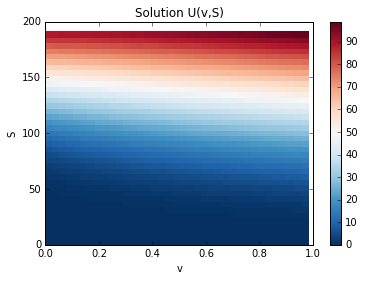

In [9]:
U_sol = numpy.reshape(U_new, [N, M])
E, X = numpy.meshgrid(v[:-12], s[:-10])

fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
sol_plot = axes.pcolor(E, X, U_sol[:-10,:-12], cmap=plt.get_cmap('RdBu_r'))
axes.set_title("Solution U(v,S)")
axes.set_xlabel("v")
axes.set_ylabel("S")
cbar = fig.colorbar(sol_plot, ax=axes)